## Executive Summary
- A decision tree model was trained to determine if a user would click-through an email or not when given the day of week and hour of day the email was sent along with the users age and gender
- The goal of the model was to maximize the true positives (predicted click-throughs that match actual click-throughs) while maintaining an overall accuracy threshold (can't just predict everyone to click-through)  
- The trained model performed exceptionally well on the test set: 100% accuracy and 100% recall (true positive rate).  This would normally be a red flag, but the patterns in this data set are so uniform and the small number of records make it possible to predict the test set precisely
- Once the model was trained on all the predictor variables, we then applied a brute force method to evaluate the probability of a click-through for all combinations of age, gender, send hour, and send day, while only knowing the users age and gender
- The outputs of this model match our expectations from the patterns seen in the data
- To run new users through the model you can input age and gender as the first two parameters into the evaluate_options function at the end of the notebook 


## Start with some exploritory analysis

**Note:** To install the required packages, uncomment and run the below cell, if the required packages are already installed on your jupyter instance you can skip this step

In [2]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
# read in the data and preview it
df_email_sends = pd.read_csv('/Users/ryan/Documents/email_sends.csv')
df_user_profiles = pd.read_csv('/Users/ryan/Documents/user_profiles.csv')

print(df_email_sends.head())
print(df_user_profiles.head())

  userId sendDay  sendHour  clickThrough
0    ym1  Monday         6          True
1    ym2  Monday         6          True
2    ym3  Monday         6          True
3    om1  Monday         6         False
4    om2  Monday         6         False
  userId gender  age  accountBalance
0    ym1   male   10             500
1    ym2   male   20             100
2    ym3   male   25             700
3    om1   male   35             800
4    om2   male   40              50


In [5]:
# confirm the data types are as expected
print(df_email_sends.dtypes)
print(df_user_profiles.dtypes)

userId          object
sendDay         object
sendHour         int64
clickThrough      bool
dtype: object
userId            object
gender            object
age                int64
accountBalance     int64
dtype: object


In [10]:
# the data and data types are as expected
# next, let's join our data into a single data frame and preview the result
# we will leave out accountBalance as per Brian's instruction
df_complete_user_data = pd.merge(df_email_sends, df_user_profiles[['userId', 'gender', 'age']], on='userId')
print('The shape of our data set is {s}'.format(s=df_complete_user_data.shape))
df_complete_user_data.head(10)


The shape of our data set is (48, 6)


,userId,sendDay,sendHour,clickThrough,gender,age
0,ym1,Monday,6,True,male,10
1,ym1,Monday,18,False,male,10
2,ym1,Friday,6,False,male,10
3,ym1,Friday,18,False,male,10
4,ym2,Monday,6,True,male,20
5,ym2,Monday,18,False,male,20
6,ym2,Friday,6,False,male,20
7,ym2,Friday,18,False,male,20
8,ym3,Monday,6,True,male,25
9,ym3,Monday,18,False,male,25


In [7]:
# run a describe on our data set
# obviously only certain metrics are calculatable for each column depending on the data type
df_complete_user_data.describe(include='all')

,userId,sendDay,sendHour,clickThrough,gender,age
count,48,48,48.000000,48,48,48.000000
unique,12,2,NaN,2,2,NaN
top,ym2,Friday,NaN,False,female,NaN
freq,4,24,NaN,36,24,NaN
mean,NaN,NaN,12.000000,NaN,NaN,29.166667
std,NaN,NaN,6.063494,NaN,NaN,12.174849
min,NaN,NaN,6.000000,NaN,NaN,10.000000
25%,NaN,NaN,6.000000,NaN,NaN,20.000000
50%,NaN,NaN,12.000000,NaN,NaN,30.000000
75%,NaN,NaN,18.000000,NaN,NaN,40.000000


Key findings from our describe function.
- There are no null values, as each column contains a count of 48
- 3/4 of the response variable observations (clickThrough) are False
- 1/2 of the emails were sent to males and half were sent to females
- 1/2 of the emails were sent on Monday (based on previewing the data it looks like Friday is the only other send day, but we'll confirm in our groupby evaluation below)

Next, we will summarize the data by the distribution of the response variable across each potential predictor variable.  This is easy to visualize using data frames considering the small nature of our data set.  If the data set was more robust we would likely visualize it differently.  For instance, histograms of positive response rates across the distribution of each predictor variable.

In [11]:
predictor_variables = ['sendDay', 'sendHour', 'gender', 'age']
for predictor in predictor_variables:
    df_clickthrough_summary = df_complete_user_data.groupby(predictor).agg(
        {'userId': 'count',
         'clickThrough': 'sum'}).reset_index()
    df_clickthrough_summary.rename(columns={'userId': 'emails_sent',
                                            'clickThrough': 'emails_clicked'}, inplace=True)
    
    df_clickthrough_summary['ctr']  =  df_clickthrough_summary['emails_clicked'] / df_clickthrough_summary['emails_sent']
    print(df_clickthrough_summary)
    print('')

  sendDay  emails_sent  emails_clicked   ctr
0  Friday           24               6  0.25
1  Monday           24               6  0.25

   sendHour  emails_sent  emails_clicked   ctr
0         6           24               6  0.25
1        18           24               6  0.25

   gender  emails_sent  emails_clicked   ctr
0  female           24               6  0.25
1    male           24               6  0.25

   age  emails_sent  emails_clicked   ctr
0   10            8               2  0.25
1   20            8               2  0.25
2   25            8               2  0.25
3   35            8               2  0.25
4   40            8               2  0.25
5   45            8               2  0.25



Interestingly, when looking at the each predictor variable individually all values have the same likelihood of yielding a user click.

Let's group 'age' and 'sendDay' and also group 'gender' and 'sendHour' together, as these combinations should produce an obvious trend as per the information provided  

In [12]:
groups = [['age', 'sendDay'], ['gender', 'sendHour']]

for group in groups:
    df_clickthrough_summary = df_complete_user_data.groupby(group).agg(
        {'userId': 'count',
         'clickThrough': 'sum'}).reset_index()
    df_clickthrough_summary.rename(columns={'userId': 'emails_sent',
                                            'clickThrough': 'emails_clicked'}, inplace=True)

    df_clickthrough_summary['ctr']  =  df_clickthrough_summary['emails_clicked'] / df_clickthrough_summary['emails_sent']
    print(df_clickthrough_summary)
    print('')

    age sendDay  emails_sent  emails_clicked  ctr
0    10  Friday            4               0  0.0
1    10  Monday            4               2  0.5
2    20  Friday            4               0  0.0
3    20  Monday            4               2  0.5
4    25  Friday            4               0  0.0
5    25  Monday            4               2  0.5
6    35  Friday            4               2  0.5
7    35  Monday            4               0  0.0
8    40  Friday            4               2  0.5
9    40  Monday            4               0  0.0
10   45  Friday            4               2  0.5
11   45  Monday            4               0  0.0

   gender  sendHour  emails_sent  emails_clicked  ctr
0  female         6           12               0  0.0
1  female        18           12               6  0.5
2    male         6           12               6  0.5
3    male        18           12               0  0.0



The data frames above clearly show the patterns descibed in the assignment description:
- Young people (< 35 years old) click on emails on Monday.
- Old people (>= 35 years old) click on emails on Fridays.
- Males click on emails in the morning (6am, 06:00hr).
- Females click on emails in the evening (6pm, 18:00hr).

These hueristics mimic the framework for a decision tree classification model 

## Building the model
We are working with a small clean data set that shows clear lifts in click through rate when sliced in different manners.  These data patterns suggest a traditional decision tree should be effective for predicting optimal send days and times to maximize the likelihood of a click-through.  We will approach this problem using a single decision tree, rather than a more complex approach like random forests or extreme gradient boosting.  The reasons for this decision are: the simplicity of the data set, clear patterns in the data, and the ease in visualizing and communicating the results of the model. 

**Note:** The objective of the model is to predict the best moment a user should receive an email, such that it will result in the greatest likelihood of a click.  Therefore, we'd like to design our model with a focus on predicting as many true positives as possible and thus we will focus mainly on recall as our model evaluation metric. 

We will also monitor accuracy, as we wouldn't want to simply predict every observation to yield a click. Our objective will be to maximize recall (the true positive rate) while maintaining accuracy above a lower bound.

First, we will format our input data so that it meets the requirements for a decision tree

In [13]:
# we will start with a set of predictor variables that we will manipulate 
original_predictor_variables = ['sendDay', 'sendHour', 'gender', 'age']

# decision trees don't inherently accept categorical variables
# so we will create binary representations of our categorical values (dummy variables)
input_data = pd.get_dummies(df_complete_user_data[original_predictor_variables], drop_first=True)

# all original categorical fields used as predictors in this data set only have two options
# therefore, we don't have to worry about ordinal data and the binary representations work fine  

The input data can now be processed by the decision tree, but we'll do one more cleanup step prior to running it through the model.  There are only 2 unique values for sendHour 6 and 18, so it's not really a continuous representation of time, but rather a binary representation of whether the message was sent at 6am or not (6pm).  I believe passing the value through as a binary would lead to a more intuitive tree interpretation for end user of this model. 

Obviously, if our data set contained a continuous representation of data we would not perform this step.

In [14]:
# update sendHour to a binary flag representing a 6am delivery or not
input_data['sendHour_6am'] = np.where(input_data['sendHour']==6, 1, 0)
input_data.drop('sendHour', axis=1, inplace=True)
input_data.head()

# note we do not need to create binary representation for 'sendHour_6pm' 
# as the complete data set is already explained using the sendHour_6am flag
# ie if sendHour_6am is 0 we know that the send hour is 6pm

,age,sendDay_Monday,gender_male,sendHour_6am
0,10,1,1,1
1,10,1,1,0
2,10,0,1,1
3,10,0,1,0
4,20,1,1,1


Now we have a set of crystal clear data that can be passed into a decision tree model.  

We will analyze a few different options for some of the input parameters to the decision tree classifier.  We won't go overboard here, due to time constraints and the simplicity of the data set.  We're essentially just looking for an appropriate depth for our tree as well as testing a hypothesis that `class_weight='balanced'` should improve our recall when we have an imbalanced class variable.

The approach of tracking fit measures of our model produced from training sets at various random states was chosen in favor of cross validation because the folds would contain a very limited amount of observations.

In [15]:
x = input_data
y = df_complete_user_data['clickThrough']

In [16]:
def evaluate_decision_tree_params(class_weight_options, depth_options, random_states):
    random_states = range(1, random_states + 1)
    depth_list = []
    class_weight_list = []
    random_state_list = []
    accuracy_list = []
    recall_list = []
    for option in class_weight_options:
        for depth in depth_options:
            for random_state in random_states:
                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                                    random_state=random_state, stratify=y)
                model = DecisionTreeClassifier(max_depth=depth, class_weight=option, criterion='entropy')
                model = model.fit(x_train, y_train)
                y_pred = model.predict(x_test)
                depth_list.append(depth)
                class_weight_list.append(option)
                random_state_list.append(random_state)
                accuracy_list.append(metrics.accuracy_score(y_test, y_pred))
                recall_list.append(metrics.recall_score(y_test, y_pred))
    df_evaluate_params = pd.DataFrame(np.column_stack([depth_list,
                                                       class_weight_list,
                                                       random_state_list,
                                                       accuracy_list,
                                                       recall_list]), 
                                      columns=['depth',
                                               'class_weight_param',
                                               'random_state',
                                               'accuracy',
                                               'recall'])

    return df_evaluate_params

In [17]:
# run through 100 random states for each set of model inputs
# decided to also evaluate a manual class_weight assignment in additon to the balanced option
df_evaluate_params = evaluate_decision_tree_params([None, 'balanced', {0:1, 1:3}], range(2,6), 100)

In [18]:
# we can see that the data types we'd like to manipulate in the group by aren't numeric, let's adjust that
df_evaluate_params.dtypes

depth                 object
class_weight_param    object
random_state          object
accuracy              object
recall                object
dtype: object

In [19]:
df_evaluate_params[['class_weight_param']] = df_evaluate_params[['class_weight_param']].astype(str)
df_evaluate_params[['depth', 'random_state']] = df_evaluate_params[['depth', 'random_state']].astype(int)
df_evaluate_params[['accuracy', 'recall']] = df_evaluate_params[['accuracy', 'recall']].astype(float)
df_evaluate_params.dtypes

depth                   int64
class_weight_param     object
random_state            int64
accuracy              float64
recall                float64
dtype: object

In [20]:
df_evaluate_params

,depth,class_weight_param,random_state,accuracy,recall
0,2,None,1,0.533333,0.50
1,2,None,2,0.666667,0.25
2,2,None,3,0.733333,0.00
3,2,None,4,0.733333,0.00
4,2,None,5,0.666667,0.00
...,...,...,...,...,...
1195,5,"{0: 1, 1: 3}",96,0.800000,0.50
1196,5,"{0: 1, 1: 3}",97,1.000000,1.00
1197,5,"{0: 1, 1: 3}",98,1.000000,1.00
1198,5,"{0: 1, 1: 3}",99,0.533333,0.25


In [21]:
# much better, now we can summarize the model evaluation metrics across options we looped through
df_evaluate_params['class_weight_param'].fillna('default', inplace=True)
df_evaluation_summary = df_evaluate_params.groupby(['depth', 'class_weight_param']).agg({
    'random_state': 'count',
    'accuracy': ['mean', 'max', 'std'],
    'recall': ['mean', 'max', 'std']}).reset_index()
df_evaluation_summary
df_evaluation_summary.columns = ['depth', 'class_weight_param', 'states_evaluated', 'accuracy_mean',
                                 'accuracy_max', 'accuracy_std', 'recall_mean',
                                 'recall_max', 'recall_std']
df_evaluation_summary

,depth,class_weight_param,states_evaluated,accuracy_mean,accuracy_max,accuracy_std,recall_mean,recall_max,recall_std
0,2,None,100,0.681333,0.733333,0.061101,0.0775,1.0,0.153639
1,2,balanced,100,0.614000,0.933333,0.184542,0.6550,1.0,0.372305
2,2,"{0: 1, 1: 3}",100,0.610000,0.933333,0.179380,0.6100,1.0,0.400946
3,3,None,100,0.616000,0.733333,0.083213,0.0825,0.5,0.155111
4,3,balanced,100,0.682000,0.933333,0.134625,0.6475,1.0,0.314014
5,3,"{0: 1, 1: 3}",100,0.667333,0.866667,0.119293,0.5875,1.0,0.308497
6,4,None,100,0.652000,1.000000,0.137830,0.2250,1.0,0.291937
7,4,balanced,100,0.699333,1.000000,0.131125,0.5175,1.0,0.310293
8,4,"{0: 1, 1: 3}",100,0.668667,1.000000,0.138115,0.4225,1.0,0.315218
9,5,None,100,0.721333,1.000000,0.147217,0.3975,1.0,0.344684


Evaluating the above output, we can see that as expected the 'balanced' option returned greater recall values for all tree depth options.  It also did not lead to any reduction in accuracy.

I decided it would be best to move forward with a tree of depth 3 while utilizing the 'balanced' option for the class_weight parameter.  This depth yields the greatest recall measures while accuracy is in line with many of the other depths.

updated: I adjusted the model to a depth of 4, when applying the model to new user data it seemed to be missing some crucial splits.  Depth of 4 yields a lower recall on average than a depth of 3, but the max value is 1, so if we initialize it on the correct random state we may return a more effective model anyway.  After the update, the model returns expected values for all test cases. 

We can now train our final model with the information we gained above

In [22]:
# grab the random state that performes best for the options we chose than train the model
df_state_options = df_evaluate_params[(df_evaluate_params['depth']==4) &
                                      (df_evaluate_params['class_weight_param']=='balanced') & 
                                      (df_evaluate_params['accuracy']>=.70)]

filtered_options = df_state_options[df_state_options['recall']==df_state_options['recall'].max()]
best_options = df_state_options[df_state_options['accuracy']==df_state_options['accuracy'].max()].reset_index()
best_state = best_options['random_state'][0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                    random_state=best_state, stratify=y)
model = DecisionTreeClassifier(max_depth=4, class_weight='balanced', criterion='entropy')
model = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('The recall for our model is: {r}'.format(r=metrics.recall_score(y_test, y_pred)))
print('The accuracy for our model is: {a}'.format(a=metrics.accuracy_score(y_test, y_pred)))

The recall for our model is: 1.0
The accuracy for our model is: 1.0


## Visualize our model results

In [23]:
x_train.columns

Index(['age', 'sendDay_Monday', 'gender_male', 'sendHour_6am'], dtype='object')

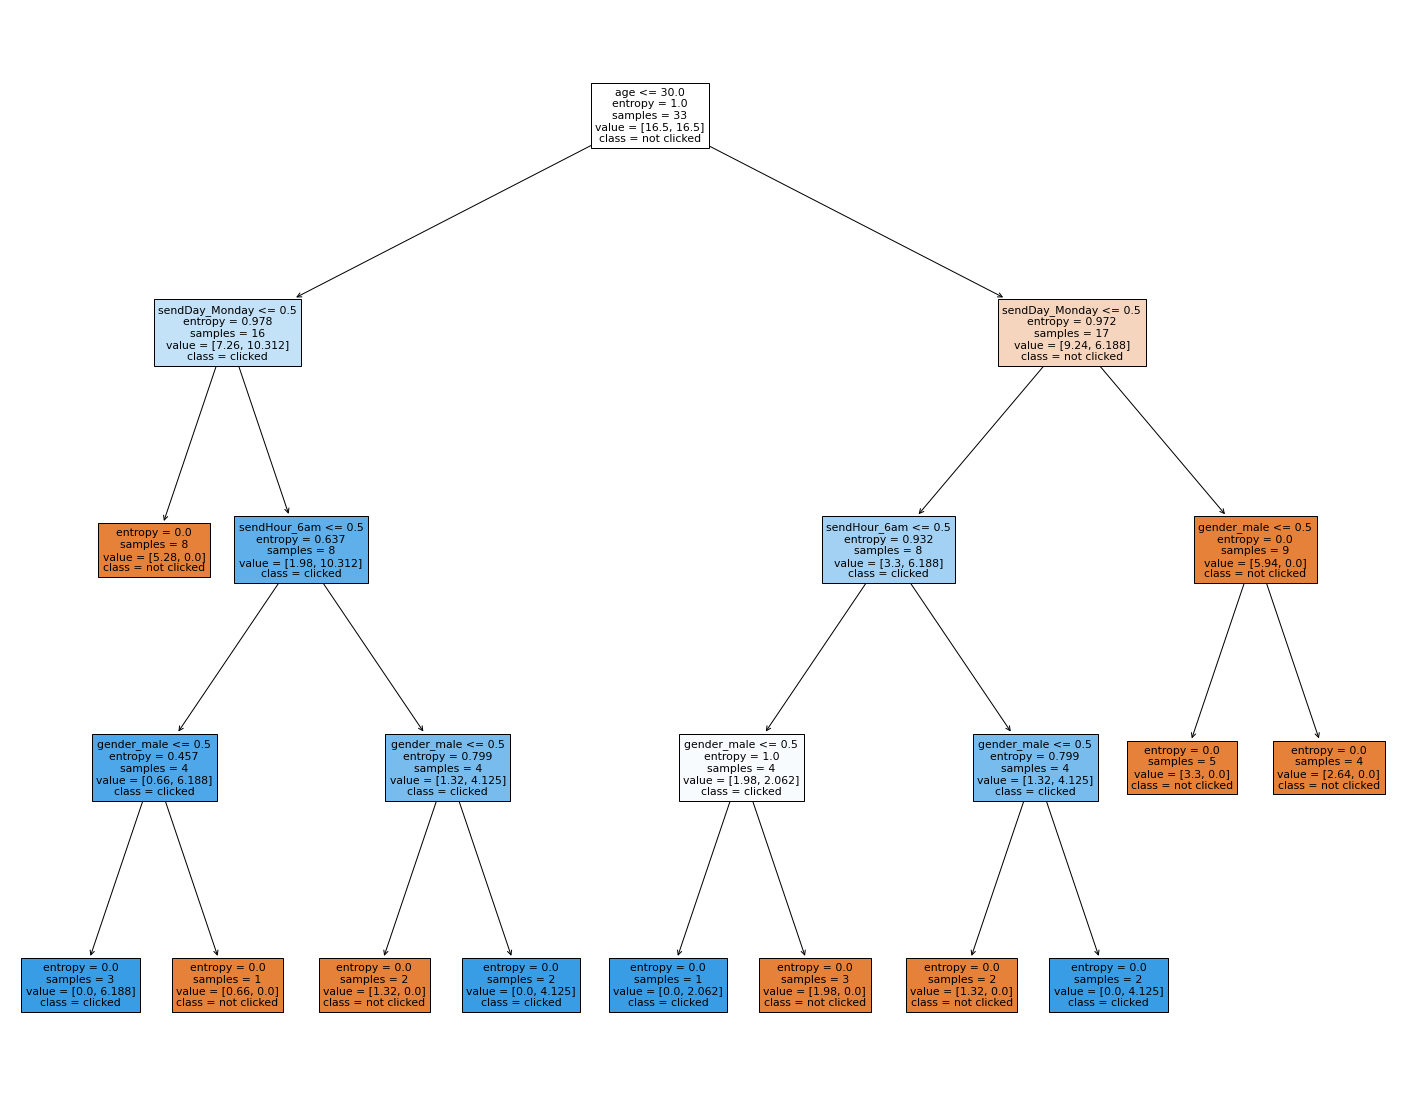

In [24]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=input_data.columns,  
                   class_names=['not clicked', 'clicked'],
                   filled=True)

Unfortunately, I didn't have time to fool around with all the decision tree formatting options to make the above decision tree visualization easily digestible.  However, if we look at some of the splits we can see that the patterns we expected from EDA are present in the decision tree.  The metric and value to split the root node is basically arbitrary from what we saw during EDA (every value grouping within each variable has the same click through rate).  Our tree decided to start by splitting on age<=30.  If we traverse the tree to the left, we see that when the send day is not Monday (aka it's Friday) and age is less or equal to 30 (as indicated by the initial split) all 8 of the training samples have not clicked-through emails.  This is what we would expect based on the pattern from the original data set shown below:

In [30]:
df_complete_user_data[(df_complete_user_data['age']<=30) & (df_complete_user_data['sendDay']=='Friday')]

,userId,sendDay,sendHour,clickThrough,gender,age
2,ym1,Friday,6,False,male,10
3,ym1,Friday,18,False,male,10
6,ym2,Friday,6,False,male,20
7,ym2,Friday,18,False,male,20
10,ym3,Friday,6,False,male,25
11,ym3,Friday,18,False,male,25
26,yf1,Friday,6,False,female,10
27,yf1,Friday,18,False,female,10
30,yf2,Friday,6,False,female,20
31,yf2,Friday,18,False,female,20


If we contined traversing all the nodes in the tree we would see many other patterns that match the original data set.  From my time at Sidecar, I have learned that end users are often wary of black box solutions.  So anytime it is possible to build an effective model with minimal complexity and decisions that can be easily understood based on the input, it is beneficial to customer adoption.

## Final Step: Applying the model to new user records

A new user won't have all the predictor variables we used to train our model.  They will only have values for 'gender' and 'age'.  We need to leverage our model such that we produce the optimal combination of the remaining predictor variables that will lead to the greatest liklihood of a click through.  Considering the remaining predictor variables only have 2 options each, we can quickly compute a brute force approach for each new user that evaluates each of the combinations of 'sendDay' and 'sendHour'.  We can then return the option that returns the greatest probability for a click through.  

In [31]:
# create a df for each sendDay sendHour combo, using our model's predictor variables
df_date_and_time_combos = pd.DataFrame({'sendDay_Monday':[0, 0, 1, 1], 
                                        'sendHour_6am':[0, 1, 0, 1]})


In [32]:
def evaluate_options(age, gender, df_date_and_time_combos, model):
    # validate input
    genders = ['male', 'female']
    if gender not in genders:
        raise ValueError('Invalid gender input. Expected one of: {}'.format(genders))
    
    #create options
    age_list = list([age]*4)
    gender_list = list([gender]*4)
    df_age_gender = pd.DataFrame(np.column_stack([age_list,
                                                  gender_list]), 
                                 columns=['age',
                                 'gender'])
    df_options = pd.concat([df_age_gender, df_date_and_time_combos], axis=1)
    df_options['gender_male'] = np.where(df_options['gender']=='male', 1, 0) 
    df_options = df_options[['age', 'sendDay_Monday', 'gender_male', 'sendHour_6am']]
    
    # score options
    y_pred = pd.Series(model.predict(df_options))
    y_probabilities = pd.DataFrame(model.predict_proba(df_options), columns=['false_probability', 'true_probability'])
    df_options = pd.concat([df_options, y_pred, y_probabilities], axis=1)
    
    # select best send time
    df_best_option = df_options[df_options['true_probability']==df_options['true_probability'].max()].reset_index()
    
    # print response
    if df_best_option['sendDay_Monday'][0]==1:
        best_day = 'Monday' 
    else:
        best_day = 'Friday'
    if df_best_option['sendHour_6am'][0]==1:
        best_time = '6am' 
    else:
        best_time = '6pm'
    print('The day and time a user of age: {a}, gender: {g} is most likely to click through an email is {d} at {t}'.format(
        a=age, g=gender, d=best_day, t=best_time))    

## Enter new user information in the first two params of the formula below
The second two params are held constant

In [33]:
evaluate_options(40, 'male', df_date_and_time_combos, model)

The day and time a user of age: 40, gender: male is most likely to click through an email is Friday at 6am


In [34]:
# I ran through a bunch to see how the results look
users_to_run_through_model = [[15, 'male'],
                              [20, 'male'],
                              [25, 'male'],
                              [30, 'male'],
                              [35, 'male'],
                              [40, 'male'],
                              [45, 'male'],
                              [50, 'male'],
                              [15, 'female'],
                              [20, 'female'],
                              [25, 'female'],
                              [30, 'female'],
                              [35, 'female'],
                              [40, 'female'],
                              [45, 'female'],
                              [50, 'female']]

for user in users_to_run_through_model:
    evaluate_options(user[0], user[1], df_date_and_time_combos, model)

The day and time a user of age: 15, gender: male is most likely to click through an email is Monday at 6am
The day and time a user of age: 20, gender: male is most likely to click through an email is Monday at 6am
The day and time a user of age: 25, gender: male is most likely to click through an email is Monday at 6am
The day and time a user of age: 30, gender: male is most likely to click through an email is Monday at 6am
The day and time a user of age: 35, gender: male is most likely to click through an email is Friday at 6am
The day and time a user of age: 40, gender: male is most likely to click through an email is Friday at 6am
The day and time a user of age: 45, gender: male is most likely to click through an email is Friday at 6am
The day and time a user of age: 50, gender: male is most likely to click through an email is Friday at 6am
The day and time a user of age: 15, gender: female is most likely to click through an email is Monday at 6pm
The day and time a user of age: 20,